In [1]:
print("heloo")

heloo


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Load dataset
df = pd.read_csv("creditcard.csv")

# Basic info
print(df.shape)
print(df.info())


(284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 2

In [9]:
print(df.columns.tolist())# Check for missing/null values
print(df.isnull().sum())

# If any are found (unlikely in this dataset), drop or fill
# df = df.dropna()   # or use df.fillna(method='ffill')


['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


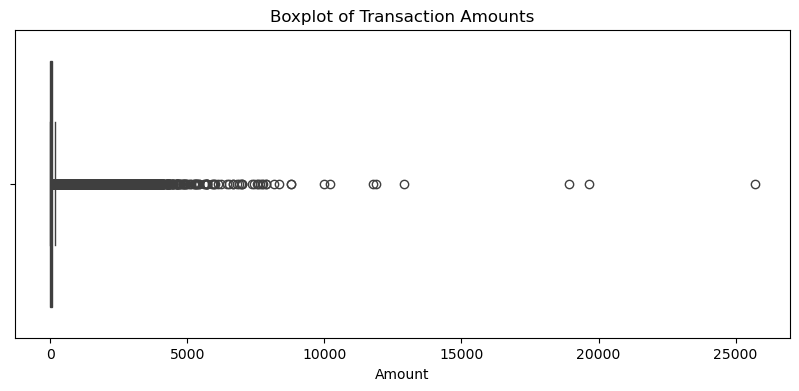

In [10]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Amount'])
plt.title("Boxplot of Transaction Amounts")
plt.show()


In [11]:
# Calculate IQR
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter dataset
df = df[(df['Amount'] >= lower_bound) & (df['Amount'] <= upper_bound)]

print("After removing outliers:", df.shape)



After removing outliers: (252903, 31)


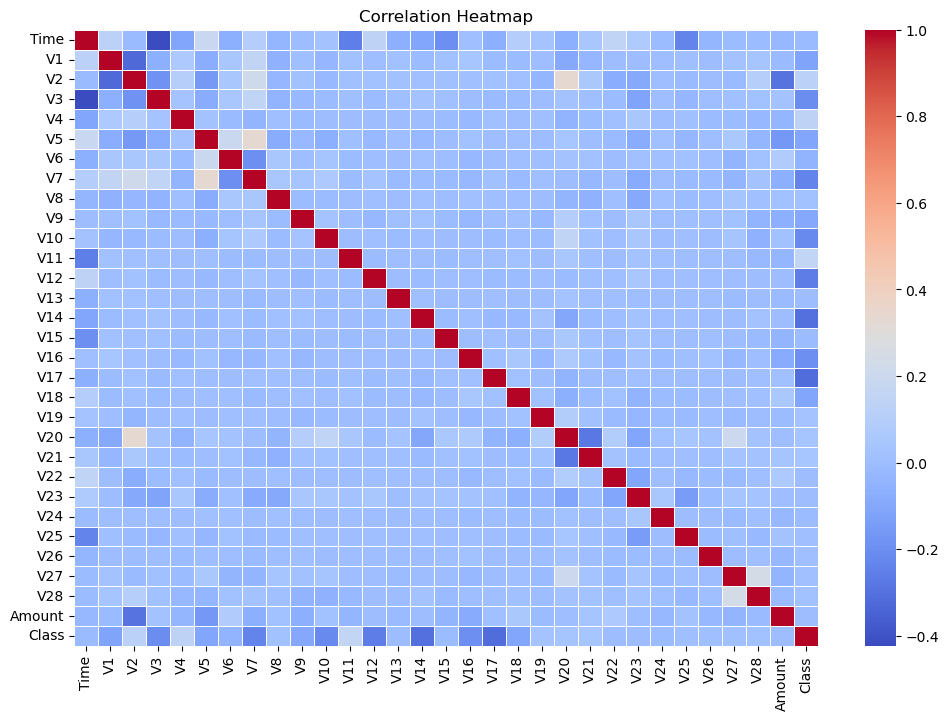

In [12]:
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


In [13]:
# Split features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Train-test split BEFORE SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: Class
0    202001
1       321
Name: count, dtype: int64
After SMOTE: Class
0    202001
1    202001
Name: count, dtype: int64


In [15]:
# Copy to avoid modifying original
X_train_scaled = X_train_smote.copy()
X_test_scaled = X_test.copy()

# Initialize scaler
scaler = StandardScaler()

# Scale 'Amount' and 'Time' columns
for col in ['Amount', 'Time']:
    X_train_scaled[col] = scaler.fit_transform(X_train_scaled[[col]])
    X_test_scaled[col] = scaler.transform(X_test_scaled[[col]])

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Train model
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train_smote)

# 2. Predictions
y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]



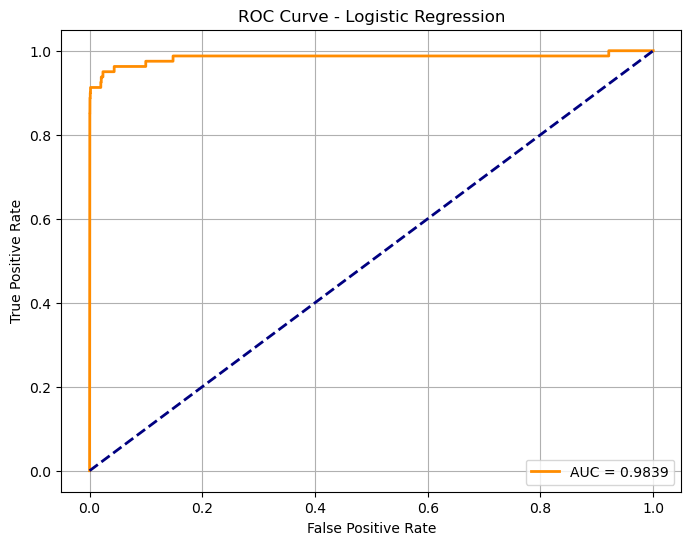

In [17]:
fpr, tpr, _ = roc_curve(y_test, y_prob_log)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid()
plt.show()


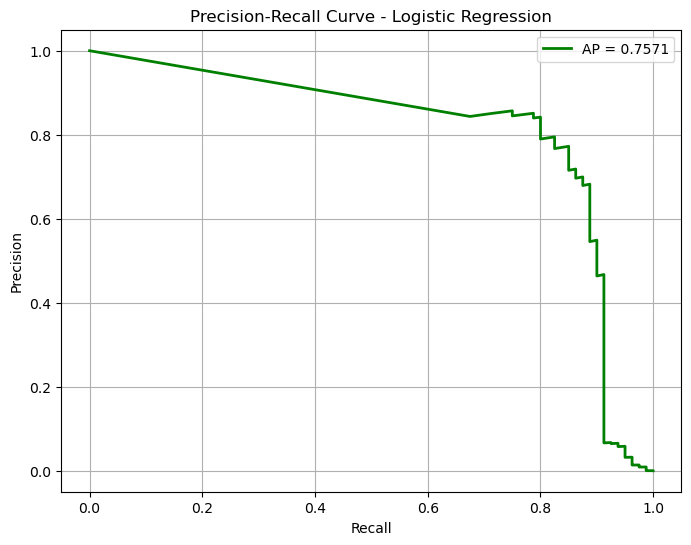

In [18]:
precision, recall, _ = precision_recall_curve(y_test, y_prob_log)
avg_precision = average_precision_score(y_test, y_prob_log)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label='AP = %0.4f' % avg_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend()
plt.grid()
plt.show()


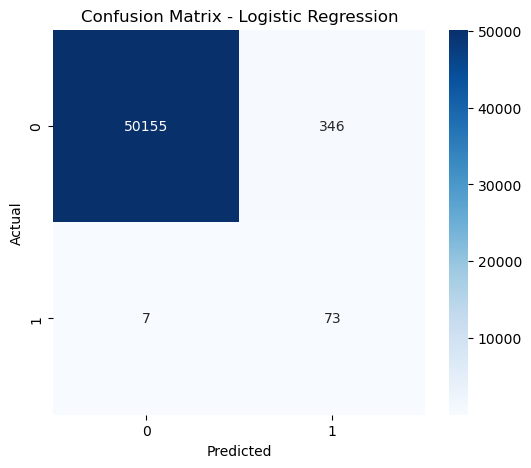

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     50501
           1       0.17      0.91      0.29        80

    accuracy                           0.99     50581
   macro avg       0.59      0.95      0.64     50581
weighted avg       1.00      0.99      1.00     50581



In [19]:
cm = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report:\n")
print(classification_report(y_test, y_pred_log))


In [20]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear']   # liblinear supports both l1 and l2
}

# Setup GridSearch
grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    param_grid,
    scoring='f1',  # Focused on imbalanced classification
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit it
grid_search.fit(X_train_scaled, y_train_smote)

# Get best model
best_log_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


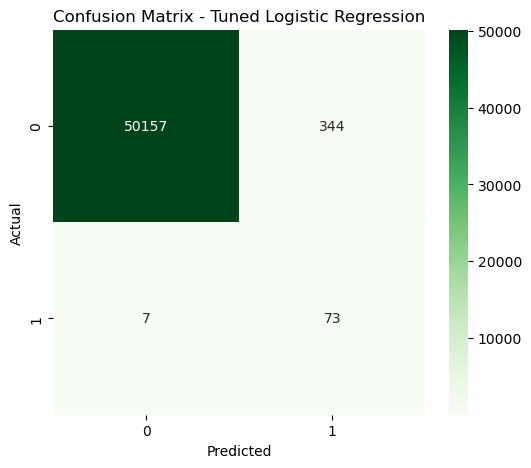

Classification Report (Tuned Model):

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     50501
           1       0.18      0.91      0.29        80

    accuracy                           0.99     50581
   macro avg       0.59      0.95      0.65     50581
weighted avg       1.00      0.99      1.00     50581



In [21]:
# Predict with best model
y_pred_best = best_log_model.predict(X_test_scaled)
y_prob_best = best_log_model.predict_proba(X_test_scaled)[:, 1]

# Confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("Classification Report (Tuned Model):\n")
print(classification_report(y_test, y_pred_best))


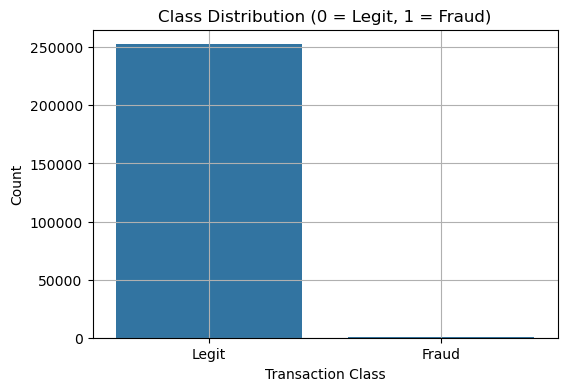

In [22]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)  # replace df with your actual dataset name if different
plt.title('Class Distribution (0 = Legit, 1 = Fraud)')
plt.xlabel('Transaction Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Legit', 'Fraud'])
plt.grid()
plt.show()


In [23]:
fraud = df[df['Class'] == 1]
legit = df[df['Class'] == 0]

print(f"Total Transactions: {len(df)}")
print(f"Legit Transactions: {len(legit)} ({(len(legit)/len(df))*100:.2f}%)")
print(f"Fraudulent Transactions: {len(fraud)} ({(len(fraud)/len(df))*100:.2f}%)")


Total Transactions: 252903
Legit Transactions: 252502 (99.84%)
Fraudulent Transactions: 401 (0.16%)


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Base model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Light parameter space
param_dist = {
    'n_estimators': randint(50, 150),              # fewer trees
    'max_depth': [None, 10, 20],                   # limited depth options
    'min_samples_split': [2, 5],                   # fewer splits to try
    'min_samples_leaf': [1, 2],                    # fewer leaf sizes
    'max_features': ['sqrt']                       # one good option
}

# MUCH LIGHTER search config
random_search = RandomizedSearchCV(estimator=rf_model,
                                   param_distributions=param_dist,
                                   n_iter=10,             # reduced from 30 to 10
                                   scoring='precision',
                                   cv=2,                  # reduced from 3 to 2
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1)             # still use all cores

# Fit the model
random_search.fit(X_train_scaled, y_train_smote)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001498CCD1670>},
                   random_state=42, scoring='precision', verbose=1)

In [26]:
best_rf_model = random_search.best_estimator_


In [27]:
y_pred_rf = best_rf_model.predict(X_test_scaled)
y_prob_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1]  # needed for curves


In [28]:
from sklearn.metrics import classification_report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50501
           1       0.88      0.86      0.87        80

    accuracy                           1.00     50581
   macro avg       0.94      0.93      0.94     50581
weighted avg       1.00      1.00      1.00     50581



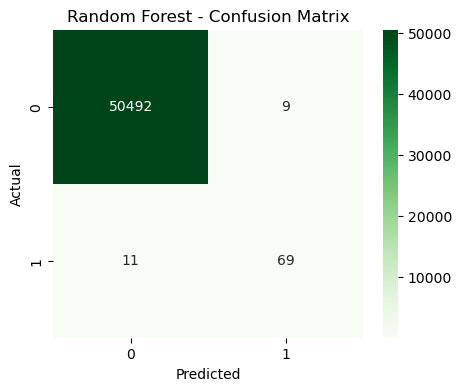

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


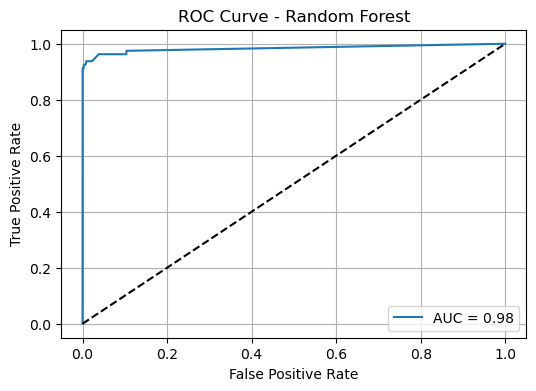

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(6,4))
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {auc_rf:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()
